In [282]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
pd.set_option('display.max_columns', None)
import numpy as np
from time import sleep
from IPython.display import clear_output

In [278]:
team_dic = {'Syracuse Nationals': 'SYR','Buffalo Braves': 'BUF','New York Nets': 'NYN','Cincinnati Royals': 'CIN','Kansas City-Omaha Kings': 'KCO',
    'Capital Bullets': 'CAP','Sacramento Kings': 'SAC','Seattle SuperSonics': 'SEA','Los Angeles Clippers': 'LAC','Washington Wizards': 'WAS',
    'New Orleans/Oklahoma City Hornets': 'NOK','Phoenix Suns': 'PHO','New Jersey Nets': 'NJN','Washington Bullets': 'WSB','Boston Celtics': 'BOS',
    'Golden State Warriors': 'GSW','Denver Nuggets': 'DEN','Vancouver Grizzlies': 'VAN','Orlando Magic': 'ORL','Chicago Bulls': 'CHI','Utah Jazz': 'UTA',
    'Toronto Raptors': 'TOR','Los Angeles Lakers': 'LAL','Portland Trail Blazers': 'POR','Memphis Grizzlies': 'MEM','Miami Heat': 'MIA',
    'New Orleans Hornets': 'NOH','San Diego Rockets': 'SDR','Atlanta Hawks': 'ATL','Oklahoma City Thunder': 'OKC','Philadelphia Warriors': 'PHW',
    'Milwaukee Bucks': 'MIL','New Orleans Jazz': 'NOJ','San Antonio Spurs': 'SAS','Charlotte Hornets': 'CHO','Brooklyn Nets': 'BRK',
    'Cleveland Cavaliers': 'CLE','San Diego Clippers': 'SDC','San Francisco Warriors': 'SFW','Rochester Royals': 'ROC','Philadelphia 76ers': 'PHI',
    'Houston Rockets': 'HOU','Fort Wayne Pistons': 'FTW','Dallas Mavericks': 'DAL','New York Knicks': 'NYK','Kansas City Kings': 'KCK',
    'Indiana Pacers': 'IND','St. Louis Hawks': 'STL','Baltimore Bullets': 'BAL','Detroit Pistons': 'DET','Minnesota Timberwolves': 'MIN','New Orleans Pelicans': 'NOP',
    'Chicago Packers': 'CHP','Charlotte Bobcats': 'CHA','Chicago Zephyrs': 'CHZ','Minneapolis Lakers': 'MNL','Charlotte Hornets\xa0': 'CHO'}

In [290]:
monthly_data = []
for month in ['october', 'november', 'december', 'january', 'february', 'march', 'april', 'may', 'june']:

    url = f'https://www.basketball-reference.com/leagues/NBA_2022_games-{month}.html'
    soup = BeautifulSoup(requests.get(url).content, 'html')
    df = pd.read_html(str(soup.find('table')))[0][['Date', 'Home/Neutral', 'Visitor/Neutral', 'PTS.1', 'PTS']]
    df = df.rename(columns = {'Visitor/Neutral': 'Away_name', 'Home/Neutral': 'Home_name', 'PTS': 'PTS_away', 'PTS.1': 'PTS_home'})
    monthly_data.append(df)
    sleep(2)

data_all = pd.concat(monthly_data)
data_all['Date'] = pd.to_datetime(data_all['Date'])
data_all['Home'] = data_all['Home_name'].apply(lambda x: team_dic.get(x))
data_all['Away'] = data_all['Away_name'].apply(lambda x: team_dic.get(x))

data_all['ID'] = data_all['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + data_all['Home'] + data_all['Away']
data_all['PTS_diff'] = data_all['PTS_home'] - data_all['PTS_away']
#data_all = data_all[['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away', 'Home_name', 'Away_name', 'PTS_diff']]

data_all.head()
    

,Date,Home_name,Away_name,PTS_home,PTS_away,Home,Away,ID,PTS_diff
0,2021-10-19,Milwaukee Bucks,Brooklyn Nets,127,104,MIL,BRK,211019MILBRK,23
1,2021-10-19,Los Angeles Lakers,Golden State Warriors,114,121,LAL,GSW,211019LALGSW,-7
2,2021-10-20,Charlotte Hornets,Indiana Pacers,123,122,CHO,IND,211020CHOIND,1
3,2021-10-20,Detroit Pistons,Chicago Bulls,88,94,DET,CHI,211020DETCHI,-6
4,2021-10-20,New York Knicks,Boston Celtics,138,134,NYK,BOS,211020NYKBOS,4


In [297]:
data_team_home = []
data_team_away = []
for step, team in enumerate(set(data_all['Home'])) :

    sleep(2)

    url = f'https://www.basketball-reference.com/teams/{team}/2022_games.html'
    page = requests.get(url)
    clear_output(wait = True)
    print(str(step+1) + '/30 ... ', team, page)

    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_='thead') is not None:
        soup.find('tr', class_='thead').decompose()
    table = soup.find('table')

    df = pd.read_html(str(table))[0]
    df = df[df['Notes'] != 'Play-In Game']
    df = df.drop(columns = ['Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 8', 'W', 'L', 'Notes'])
    df = df.rename(columns = {'Tm': 'PTS', 'Opp': 'PTS_opp', 'Unnamed: 7' : 'W', 'Unnamed: 5': 'Venue'})

    df['Team'] = len(df) * [team]
    df['W'] = df['W'].replace('W', 1).replace('L', 0)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Opponent'] = df['Opponent'].apply(lambda x: team_dic.get(x))
    df['Venue'] = df['Venue'].replace(np.nan, 1).replace('@', 0)

    def streak(str):
        wl, n = str.split()
        if wl == 'W':
            return int(n)
        if wl == 'L':
            return -int(n)
    df['Streak'] = df['Streak'].apply(streak)
    df['Streak'] = [np.nan] + list(df['Streak'])[:-1]

    for stat, underlying_stat in zip(['W/L%', 'ORtg', 'DRtg'], ['W', 'PTS', 'PTS_opp']):
        
        df[stat] = [np.nan] + list(df[underlying_stat].rolling(1000, min_periods = 1).mean())[:-1]
        for w in [1, 2, 5, 10, 25]:
            df[stat + '_' + str(w)] = [np.nan] + list(df[underlying_stat].rolling(w, min_periods = 1).mean())[:-1]

    df_home = df.groupby('Venue').get_group(1)
    df_home = df_home.drop(columns = ['Venue'])
    for col in list(df_home):
        df_home = df_home.rename(columns = {col: col + '_home'})
    df_home = df_home.rename(columns = {'Date_home': 'Date', 'Opponent_home': 'Away', 'PTS_opp_home': 'PTS_away', 'Team_home': 'Home'})
    df_home['ID'] = df_home['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_home['Home'] + df_home['Away']

    df_away = df.groupby('Venue').get_group(0)
    df_away = df_away.drop(columns = ['Venue'])
    for col in list(df_away):
        df_away = df_away.rename(columns = {col: col + '_away'})
    df_away = df_away.rename(columns = {'Date_away': 'Date', 'Opponent_away': 'Home', 'PTS_opp_away': 'PTS_home', 'Team_away': 'Away'})
    df_away['ID'] = df_away['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_away['Home'] + df_away['Away']

    data_team_home.append(df_home)
    data_team_away.append(df_away)

homes = pd.concat(data_team_home)
aways = pd.concat(data_team_away)
    

data = homes.merge(aways, on = ['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

features = [x for x in list(data) if 'W/L%' in x or 'ORtg' in x or 'DRtg' in x or 'Streak' in x]
data = data[['ID', 'Date', 'G_home', 'G_away', 'Home', 'Away', 'W_home', 'PTS_home', 'PTS_away', 'PTS_diff'] + features]


30/30 ...  BOS <Response [200]>


In [298]:
data.head()

,ID,Date,G_home,G_away,Home,Away,W_home,PTS_home,PTS_away,PTS_diff,Streak_home,W/L%_home,W/L%_1_home,W/L%_2_home,W/L%_5_home,W/L%_10_home,W/L%_25_home,ORtg_home,ORtg_1_home,ORtg_2_home,ORtg_5_home,ORtg_10_home,ORtg_25_home,DRtg_home,DRtg_1_home,DRtg_2_home,DRtg_5_home,DRtg_10_home,DRtg_25_home,Streak_away,W/L%_away,W/L%_1_away,W/L%_2_away,W/L%_5_away,W/L%_10_away,W/L%_25_away,ORtg_away,ORtg_1_away,ORtg_2_away,ORtg_5_away,ORtg_10_away,ORtg_25_away,DRtg_away,DRtg_1_away,DRtg_2_away,DRtg_5_away,DRtg_10_away,DRtg_25_away
0,211019MILBRK,2021-10-19,1,1,MIL,BRK,1,127,104,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,211019LALGSW,2021-10-19,1,1,LAL,GSW,0,114,121,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,211020PORSAC,2021-10-20,1,1,POR,SAC,0,121,124,-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,211020SASORL,2021-10-20,1,1,SAS,ORL,1,123,97,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,211020MEMCLE,2021-10-20,1,1,MEM,CLE,1,132,121,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

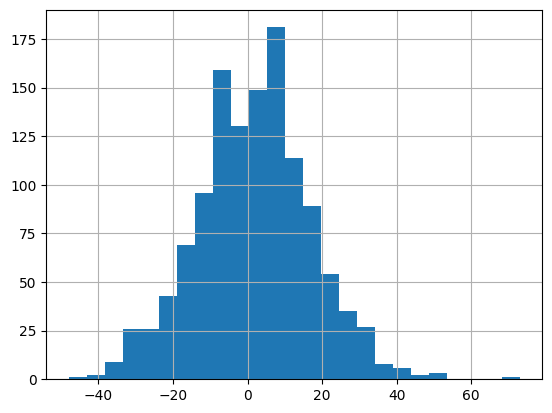

In [301]:
data['PTS_diff'].hist(bins = 25)

In [300]:
data.shape

(1230, 48)